In [11]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

### Quote Data preparation for training Hidden Markov Models on High-Frequency Quote Data

- Data preprocessing and cleaning
- Parsing observation vectors from raw data
- Labelling hidden states within training dataset

In [26]:
quotes=pd.read_csv('data/AAPL_quotes_2020_cleaned.csv',index_col=0,on_bad_lines = 'warn',nrows=2500000)
quotes.index=pd.to_datetime(quotes.index)
quotes=quotes[quotes.index<datetime(2020,2,1)]

for _,d in quotes.groupby('date'):
    d.to_csv(f'data/AAPL_quotes_{_}.csv')

2020-01-02 09:30:03.296828    2020-01-02
2020-01-02 09:30:05.489204    2020-01-02
2020-01-02 09:30:05.663684    2020-01-02
2020-01-02 09:30:06.278858    2020-01-02
2020-01-02 09:30:14.710996    2020-01-02
                                 ...    
2020-01-31 15:59:30.029318    2020-01-31
2020-01-31 15:59:35.478465    2020-01-31
2020-01-31 15:59:36.008865    2020-01-31
2020-01-31 15:59:42.009852    2020-01-31
2020-01-31 15:59:43.831412    2020-01-31
Name: date, Length: 1843801, dtype: object
data/AAPL_quotes_2020-01-02.csv
data/AAPL_quotes_2020-01-03.csv
data/AAPL_quotes_2020-01-06.csv
data/AAPL_quotes_2020-01-07.csv
data/AAPL_quotes_2020-01-08.csv
data/AAPL_quotes_2020-01-09.csv
data/AAPL_quotes_2020-01-10.csv
data/AAPL_quotes_2020-01-13.csv
data/AAPL_quotes_2020-01-14.csv
data/AAPL_quotes_2020-01-15.csv
data/AAPL_quotes_2020-01-16.csv
data/AAPL_quotes_2020-01-17.csv
data/AAPL_quotes_2020-01-21.csv
data/AAPL_quotes_2020-01-22.csv
data/AAPL_quotes_2020-01-23.csv
data/AAPL_quotes_2020-01-2

In [27]:
quotes_jan_2=pd.read_csv('data/AAPL_quotes_2020-01-02.csv',index_col=0)



quotes_jan_2=quotes_jan_2[['Exchange','Symbol','Bid_Price','Bid_Size','Offer_Price','Offer_Size']].copy()

quotes_jan_2['OB_IB']=quotes_jan_2['Offer_Size']/quotes_jan_2['Bid_Size']
quotes_jan_2['spread']=quotes_jan_2['Offer_Price']-quotes_jan_2['Bid_Price']
quotes_jan_2

,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,OB_IB,spread
2020-01-02 09:30:03.296828,N,AAPL,295.70,1.0,296.75,6.0,6.000000,1.05
2020-01-02 09:30:05.489204,N,AAPL,296.14,4.0,296.75,5.0,1.250000,0.61
2020-01-02 09:30:05.663684,N,AAPL,295.70,1.0,296.75,5.0,5.000000,1.05
2020-01-02 09:30:06.278858,N,AAPL,294.05,1.0,296.12,2.0,2.000000,2.07
2020-01-02 09:30:14.710996,N,AAPL,295.12,1.0,295.74,1.0,1.000000,0.62
...,...,...,...,...,...,...,...,...
2020-01-02 15:59:41.175398,N,AAPL,300.41,2.0,300.66,1.0,0.500000,0.25
2020-01-02 15:59:46.113982,N,AAPL,300.29,3.0,300.46,1.0,0.333333,0.17
2020-01-02 15:59:50.118942,N,AAPL,300.29,3.0,300.66,1.0,0.333333,0.37
2020-01-02 15:59:52.913707,N,AAPL,300.29,3.0,300.66,1.0,0.333333,0.37


### Analysis of Features

- Discuss the idea of normalization and how we avoided the procedure
- Assume there are hidden states responsible for the DGP; where two density functions are intertwined throughout time
- Log-Normalization for robustness against outliers
- Parametric Normalization (Mean/SD) of the data will make these less separable 

In [28]:
features=quotes_jan_2[['Bid_Size', 'Offer_Size', 'spread','OB_IB']].copy()

features.index=pd.to_datetime(features.index)
features['sec']=[i.round('1s') for i in features.index]

grouped_features=features.groupby('sec').mean()

bidsize=np.log(grouped_features['Bid_Size'].values+1)
offersize=np.log(grouped_features['Offer_Size'].values+1)
bookimbalance=np.log(grouped_features['OB_IB'].values+1)
spread=np.log(grouped_features['spread'].values+1)


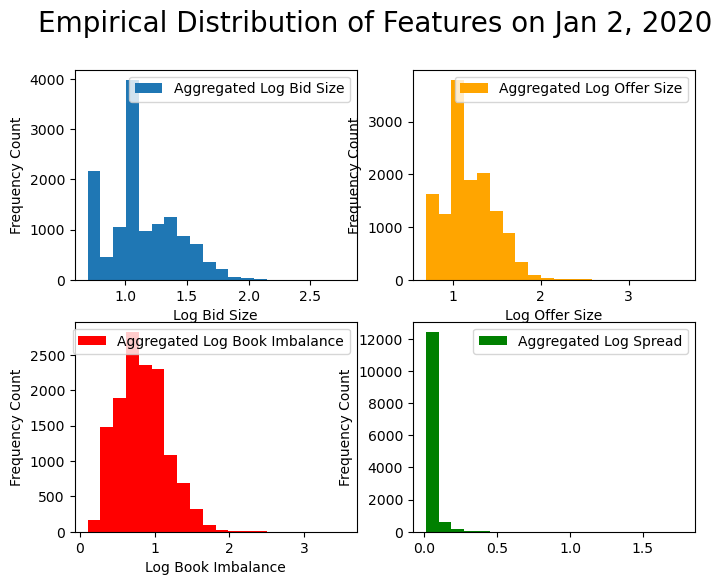

In [39]:
fig,ax=plt.subplots(2,2,figsize=(8,6))
fig.suptitle('Empirical Distribution of Features on Jan 2, 2020', fontsize=20)
ax[0][0].hist(bidsize,label='Aggregated Log Bid Size',bins=20)
ax[0][1].hist(offersize, label='Aggregated Log Offer Size',color='orange',bins=20)
ax[1][0].hist(bookimbalance,label='Aggregated Log Book Imbalance',color='red',bins=20)
ax[1][1].hist(spread, label='Aggregated Log Spread',color='green',bins=20)

ax[0][0].set_xlabel("Log Bid Size")
ax[0][1].set_xlabel("Log Offer Size")
ax[1][0].set_xlabel("Log Book Imbalance")
ax[1][1].set_ylabel("Log Spread")

ax[0][0].set_ylabel("Frequency Count")
ax[0][1].set_ylabel("Frequency Count")
ax[1][0].set_ylabel("Frequency Count")
ax[1][1].set_ylabel("Frequency Count")


ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()


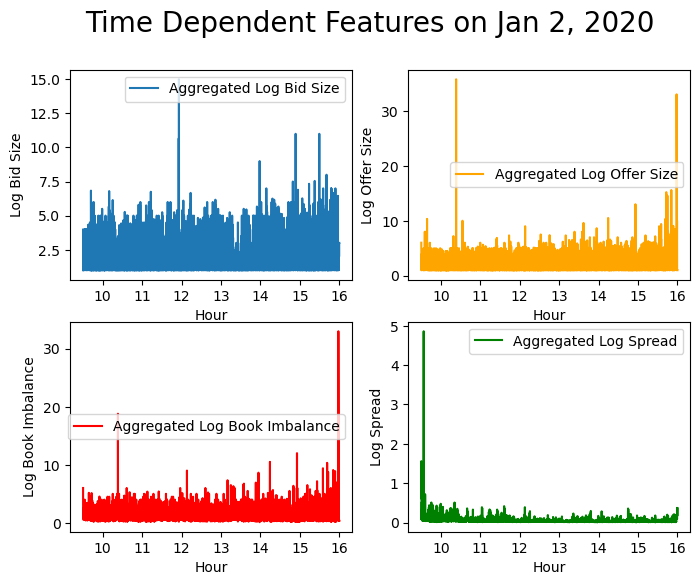

In [38]:
fig,ax=plt.subplots(2,2,figsize=(8,6))
fig.suptitle('Time Dependent Features on Jan 2, 2020', fontsize=20)
ax[0][0].plot(grouped_features['Bid_Size'],label='Aggregated Log Bid Size')
ax[0][1].plot(grouped_features['Offer_Size'], label='Aggregated Log Offer Size',color='orange')
ax[1][0].plot(grouped_features['OB_IB'],label='Aggregated Log Book Imbalance',color='red')
ax[1][1].plot(grouped_features['spread'], label='Aggregated Log Spread',color='green')
formatter = matplotlib.dates.DateFormatter('%H')
ax[0][0].xaxis.set_major_formatter(formatter)
ax[0][1].xaxis.set_major_formatter(formatter)
ax[1][0].xaxis.set_major_formatter(formatter)
ax[1][1].xaxis.set_major_formatter(formatter)
ax[0][0].set_xlabel("Hour")
ax[0][1].set_xlabel("Hour")
ax[1][0].set_xlabel("Hour")
ax[1][1].set_xlabel("Hour")

ax[0][0].set_ylabel("Log Bid Size")
ax[0][1].set_ylabel("Log Offer Size")
ax[1][0].set_ylabel("Log Book Imbalance")
ax[1][1].set_ylabel("Log Spread")

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()

### Label states of aggregated data

Given our trained model we can make predictions of state of 
    - Bid Size
    - Offer Size
    - OBIB
    - Spread

And compute parametric tests on testing data to determine the significance of our model across the set 

 



In [31]:
#label state as 1 or -1 based on widen or tighten
def label_spread(x):
    if x['spread']>x['last_spread']:
        # spread widens
        return 1
    elif x['spread']<x['last_spread']:
        # spread tightens 
        return -1
    else:
        return 0

In [ ]:
grouped_features['last_spread']=grouped_features['spread'].shift(-1)
grouped_features['spread_state']=grouped_features.apply(lambda x: label_spread(x),axis=1)
grouped_features=grouped_features.dropna()
grouped_features.to_csv('data/grouped_features.csv')